In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [2]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/dlca

/content/drive/MyDrive/dlca


In [5]:
!ls

data  fluid-andrin-v0  TEST


# UTILS

In [6]:
hidden_channels = 3
n_channels = 1 + hidden_channels
alpha = 0.01
size = 256

In [13]:
def grayscale_m(x):
    return x[0,:,:,0]

def rgb_m(x):
    return x[0,:,:,:3]

def plot(x):
    plt.imshow(grayscale_m(x), cmap='Greys' , vmin = 0)
    plt.show()

def save_plot(x, filename):
    plt.imshow(grayscale_m(x), cmap='Greys',  vmin = 0)
    plt.savefig(str(filename) + '.png')

def mask_edges(x):
  x[0,0,:,0] = np.zeros(size)
  x[0,:,0,0] = np.zeros(size)
  x[0,:,size-1,0] = np.zeros(size)
  x[0,size-1,:,0] = np.zeros(size)
  return x

def get_living_mask(x):
    channel_alpha = x[:, :, :, 0]
    #return tf.nn.max_pool2d(channel_alpha, 3, [1, 1, 1, 1], 'SAME') > alpha
    return np.expand_dims(channel_alpha > alpha, axis=-1)

def modelToGif(model , start_frame , steps , interval = 1 , mask=False, rgb=False , fps=8):
  x = start_frame
  main_channel = []
  hidden_channel = []
  for i in range(steps):
      if i % interval == 0:
        if rgb : 
          main_channel.append(np.absolute(x.numpy()[0][:,:,:3]))
          hidden_channel.append(np.absolute(x.numpy()[0][:,:,3:]))
        else: 
          main_channel.append(x.numpy()[0][:,:,0])
          hidden_channel.append(x.numpy()[0][:,:,1:])
      x = model(x , mask=mask)
  videos = {
    'main channel': main_channel,
    'hidden channel': hidden_channel,
  }

  media.show_videos(videos, height=size, fps=fps, codec='gif', border=True)
  return videos


def datasetToFrames(ds , grayscale = False):
  video = []
  for i in ds:
    if grayscale:
       video.append(i[0][:,:,0])
    else:
      video.append(i[0])
  return video

def toGif(frames):
  media.show_video(frames, height=size, fps=8, codec='gif', border=True)

# Datasets

(1, 256, 256, 1)



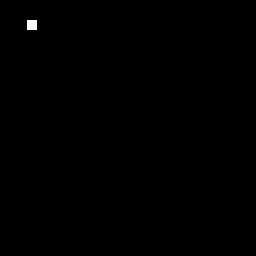

(1, 256, 256, 1)



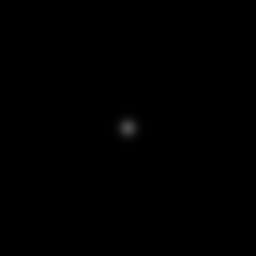

(1, 256, 256, 2)
(1, 256, 256, 1)



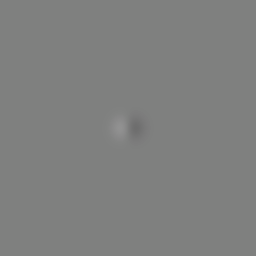

In [14]:
#@title Initialize Training { vertical-output: true}
def getFallingSquareDS():
  dataset = []
  for i in range(60):
    base = np.zeros((1,size,size,1))
    length = 10
    idx , idy = 20,27
    idx += i
    base[:,idx:idx+length,idy:idy+length] = np.ones(1)
    dataset.append(base)
  return dataset

def getDyeDS():
  dataset = []
  for i in range(90):
    filename = f'data/frame_dye_{i:05d}.png'
    img = tf.keras.preprocessing.image.load_img(path=filename, color_mode='grayscale', target_size=(size, size))
    img = np.expand_dims(np.array(img), axis=2)
    img = tf.expand_dims(img, 0)
    dataset.append(img.numpy())
  return dataset

def getCurlDS():
  dataset = []
  for i in range(90):
    filename = f'data/frame_vel_{i:05d}.png'
    img = tf.keras.preprocessing.image.load_img(path=filename, color_mode='rgb', target_size=(size, size))
    img = tf.expand_dims(np.array(img), 0) / 255
    dataset.append(img.numpy()[:,:,:,:2])
  return dataset

def getVelDS():
  dataset = []
  for i in range(90):
    filename = f'data/frame_curl_{i:05d}.png'
    img = tf.keras.preprocessing.image.load_img(path=filename, color_mode='grayscale', target_size=(size, size))
    img = np.expand_dims(np.array(img), axis=2)
    img = tf.expand_dims(np.array(img), 0) /255
    dataset.append(img.numpy())
  return dataset


dsSquareFall = getFallingSquareDS()
print(dsSquareFall[0].shape)
toGif(datasetToFrames(dsSquareFall , True))

dsDye = getDyeDS()
print(dsDye[0].shape)
toGif(datasetToFrames(dsDye ,  True))

dsCurl = getCurlDS()
print(dsCurl[0].shape)
#toGif(datasetToFrames(dsCurl))

dsVel = getVelDS()
print(dsVel[0].shape)
toGif(datasetToFrames(dsVel ,  True))

# Model Neural Cellular Automata

In [15]:
#@title Initialize Training { vertical-output: true}
class NNA(tf.keras.Model):

    def __init__(self, n_channels):
        super().__init__()
        self.channel_n = n_channels
        self.alpha = alpha

        self.dmodel = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 1, activation=tf.nn.relu),
            tf.keras.layers.Conv2D(self.channel_n, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        self(tf.zeros([1, 3, 3, n_channels]))

    def perceive(self, x):
        cellID = tf.constant([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]], dtype=tf.float32)
        sobelX = tf.constant([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=tf.float32)
        sobelY = tf.constant([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=tf.float32)

        kernel = tf.stack([cellID, sobelX, sobelY], -1)[:, :, None, :]
        kernel = tf.repeat(kernel, self.channel_n, 2)

        y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
        return y

    def call(self, x, steps = 1 , mask = False):
        if mask:
          pre_live_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y) * steps

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= 0.5
        x += dx * tf.cast(update_mask, tf.float32)

        if mask:
          post_life_mask = get_living_mask(x)
          life_mask = pre_live_mask | post_life_mask
          life_mask = mask_edges(life_mask)
          return x * tf.cast(life_mask, tf.float32)

        return x

model = NNA(n_channels)
model.summary()

Model: "nna"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 3, 3, 4)              2180      
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________


# Sim

In [16]:
dataset = dsDye

lr = 2e-03
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000], [lr, lr*0.05])
optimizer = tf.keras.optimizers.Adam(lr_sched)
loss_object = tf.keras.losses.MeanSquaredError()

start_frame = 0
end_frame = len(dataset)-1
max_frame_steps = 10
extra_steps = 10

Epoch 0 , Loss 0.60382080078125



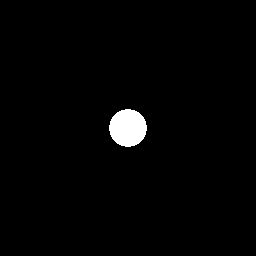
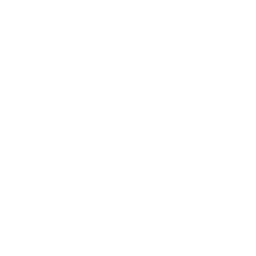

Epoch 500 , Loss 25.06096076965332



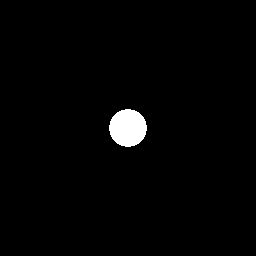
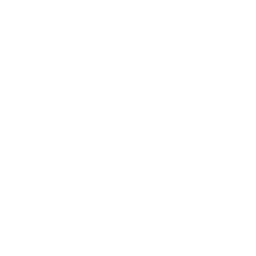

Epoch 1000 , Loss 63.676265716552734



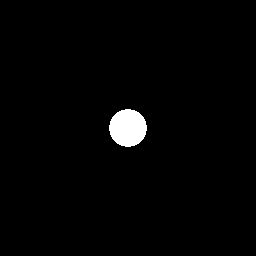
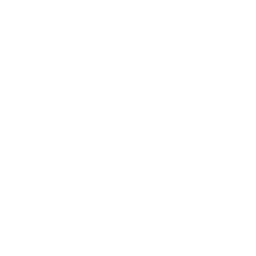

Epoch 1500 , Loss 22.82550811767578



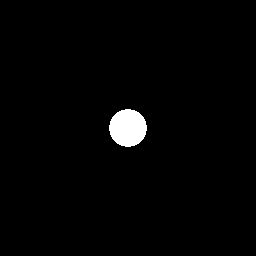
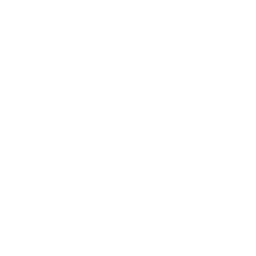

KeyboardInterrupt: ignored

In [12]:
model = NNA(n_channels)

start_frame = 0
end_frame = 40
max_frame_steps = 10
extra_steps = 20

init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,size,size,hidden_channels))) , axis = -1))

#@title Dye : Loss frame + mask + rand init frame + 5 extra steps { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    frame_steps = tf.random.uniform([],1,max_frame_steps,tf.int32)
    loss = 0
    random_frame_idx = np.random.randint(start_frame,end_frame-max_frame_steps)
    x = tf.convert_to_tensor(np.concatenate((dataset[random_frame_idx],np.ones((1,size,size,hidden_channels))) , axis = -1))
    with tf.GradientTape() as g:        
        for i in tf.range(frame_steps):
          for j in tf.range(extra_steps):
              x = model(x , mask= True)
        loss += loss_object(grayscale_m(dataset[random_frame_idx+frame_steps]), grayscale_m(x))
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 10001
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 500 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init ,1000 , interval=50 ,  mask= True)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

In [ ]:
from keras.applications.vgg16 import VGG16
import keras

In [ ]:
basemodel = VGG16(include_top = False)    
nb_layers = 3
modelvgg = tf.keras.Sequential(basemodel.layers[:nb_layers])
modelvgg.add(keras.layers.Conv2D(32, (7, 7), activation = 'relu'))

for layer in modelvgg.layers[:nb_layers+1]:
    layer.trainable = False

modelvgg.summary()

In [8]:
def checkerboard(shape, tile_size):
    return (np.indices(shape) // tile_size).sum(axis=0) % 2
ckbrd = checkerboard((1,256,256,3),16)
ckbrd = ckbrd + 0.5

In [9]:
x = dataset[0]
x = np.tile(x, (1, 1, 1, 3))
x = modelvgg(x)
print(x.shape)

NameError: ignored

In [10]:
x = modelvgg(ckbrd)
print(x.shape)

NameError: ignored

In [26]:
x = np.ones((256,256))
x = np.stack((x,)*3, axis=-1)
print(x.shape)

(256, 256, 3)


In [27]:
# target_sim: grayscale,  target_style: rgb , x: greyscale
def getVGGLoss( target_sim,  target_style , x):
  x_vgg = modelvgg(target_style) # use target_sim as mask
  x_sim = modelvgg(np.expand_dims(np.stack((x,x,x), axis=-1), axis=0))
  return loss_object(x_vgg , x_sim)

Epoch 0 , Loss 8496.576171875



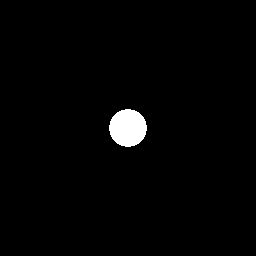
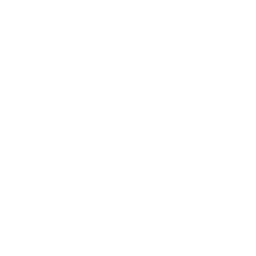

Epoch 50 , Loss 420.6958312988281



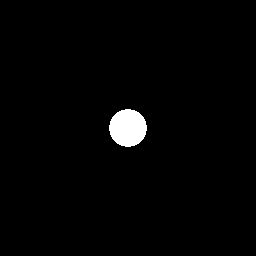
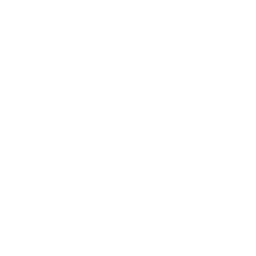

Epoch 100 , Loss 4390.48681640625



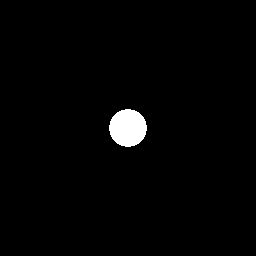
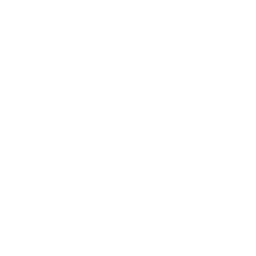

Epoch 150 , Loss 3131.514404296875



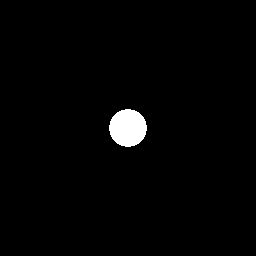
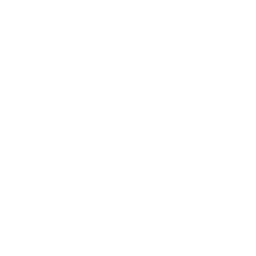

Epoch 200 , Loss 4813.77294921875



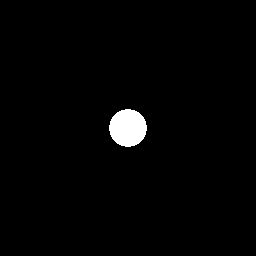
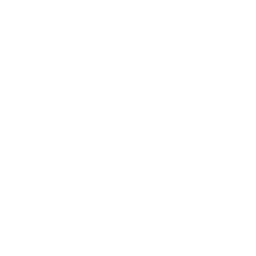

Epoch 250 , Loss 2656.632568359375



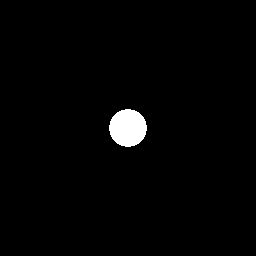
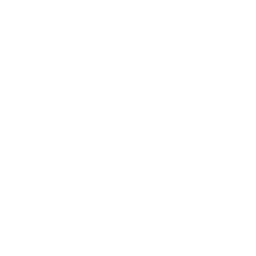

Epoch 300 , Loss 2400.14404296875



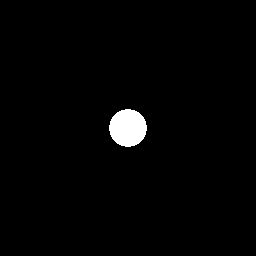
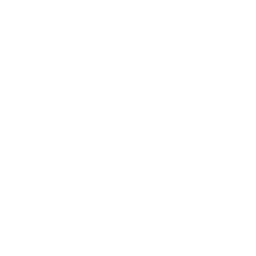

Epoch 350 , Loss 868.982177734375



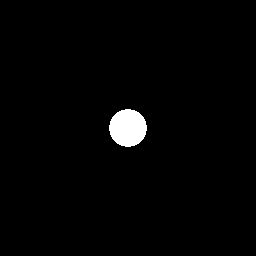
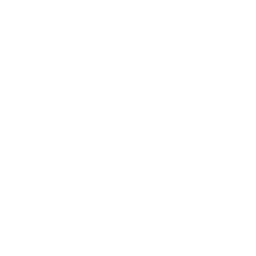

Epoch 400 , Loss 1167.126708984375



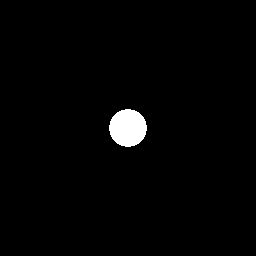
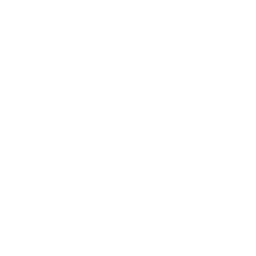

Epoch 450 , Loss 1145.0703125



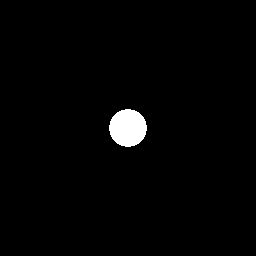
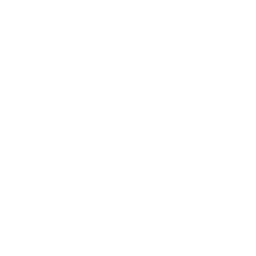

Epoch 500 , Loss 5644.1953125



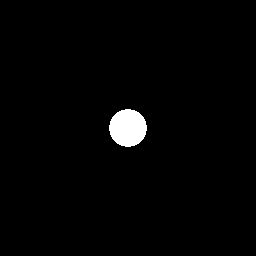
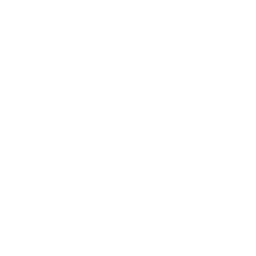

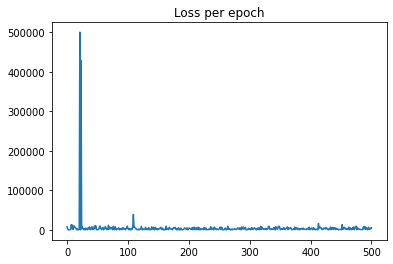

In [ ]:
model = NNA(n_channels)

start_frame = 0
end_frame = 40
max_frame_steps = 10
extra_steps = 20

init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,size,size,hidden_channels))) , axis = -1))

#@title lets try to add some styling { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    frame_steps = tf.random.uniform([],1,max_frame_steps,tf.int32)
    loss = 0
    random_frame_idx = np.random.randint(start_frame,end_frame-max_frame_steps)
    x = tf.convert_to_tensor(np.concatenate((dataset[random_frame_idx],np.ones((1,size,size,hidden_channels))) , axis = -1))
    with tf.GradientTape() as g:        
        for i in tf.range(frame_steps):
          for j in tf.range(extra_steps):
              x = model(x , mask= True)
        
        loss_classic = loss_object(grayscale_m(dataset[random_frame_idx+frame_steps]), grayscale_m(x))
        loss_vgg = getVGGLoss( dataset[random_frame_idx+frame_steps] , ckbrd , grayscale_m(x)   )
        loss += (loss_classic + loss_vgg)
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 50 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init ,1000 , interval=50 ,  mask= True)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()

In [ ]:
# target_sim: grayscale,  target_style: rgb , x: greyscale
def getVGGLoss( target_sim,  target_style , x):
  x_vgg = modelvgg(target_style) # use target_sim as mask
  x_sim = modelvgg(np.expand_dims(np.stack((x,x,x), axis=-1), axis=0))
  return loss_object(x_vgg , x_sim)

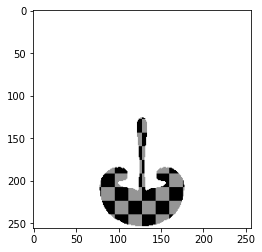

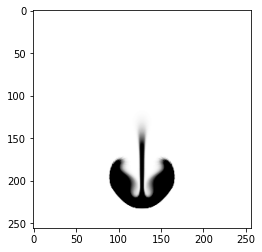

Epoch 0 , Loss 223.85104370117188



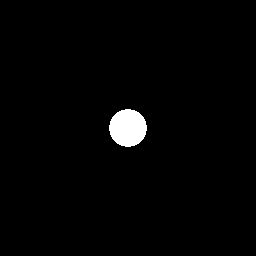
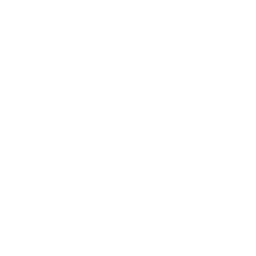

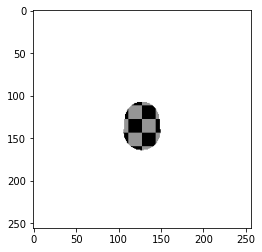

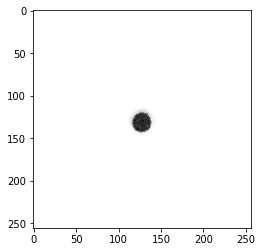

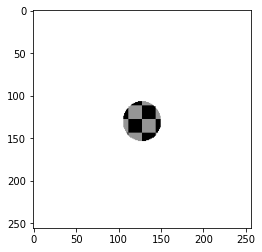

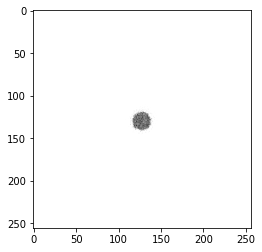

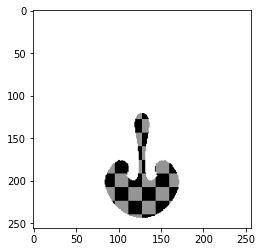

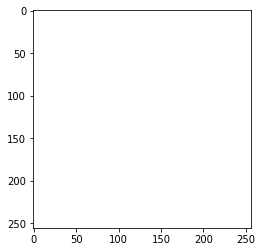

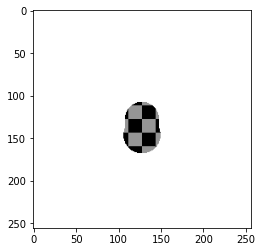

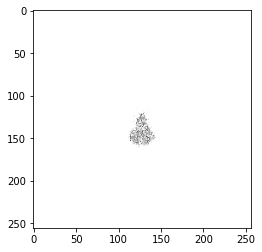

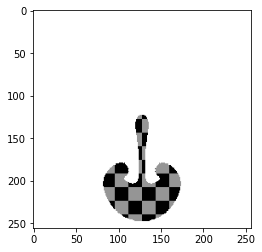

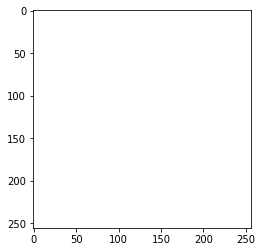

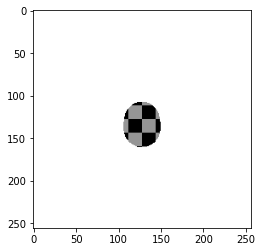

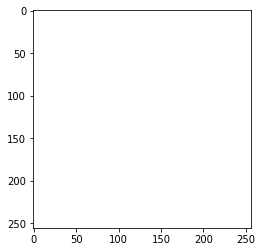

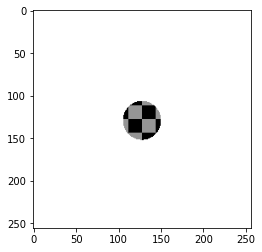

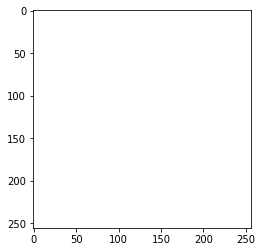

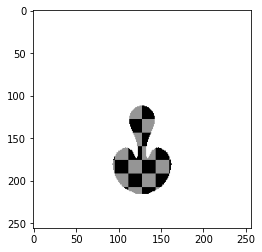

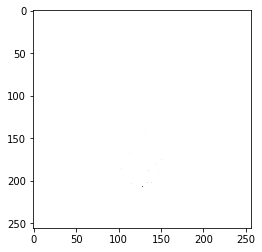

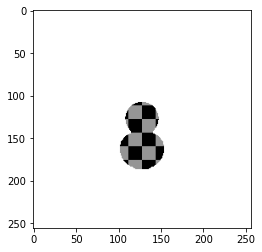

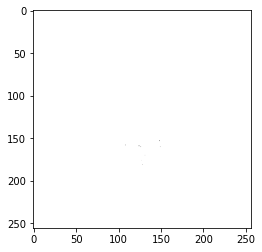

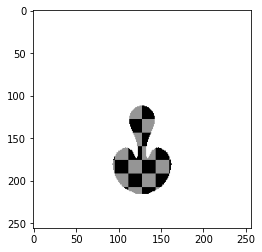

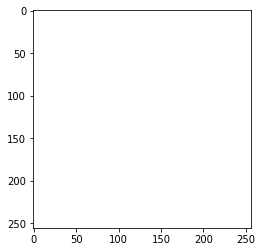

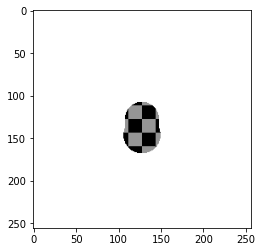

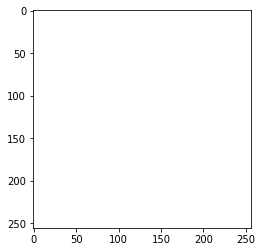

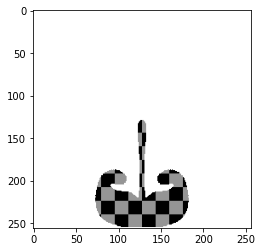

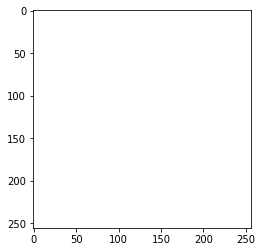

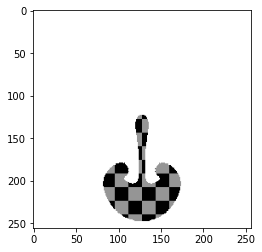

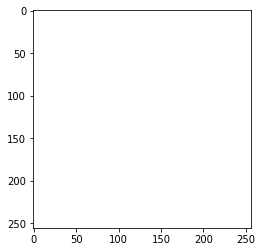

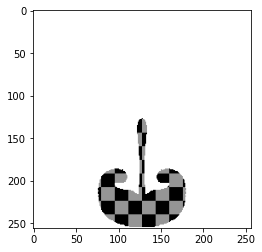

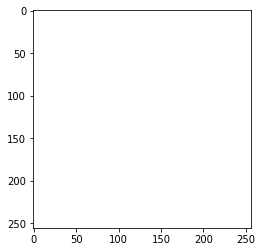

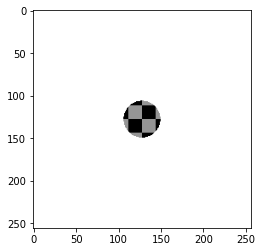

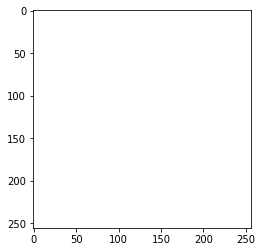

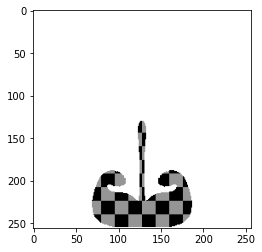

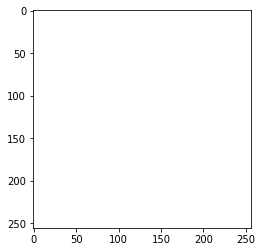

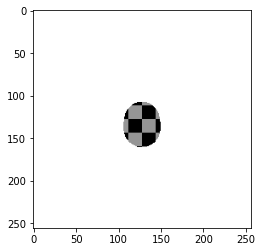

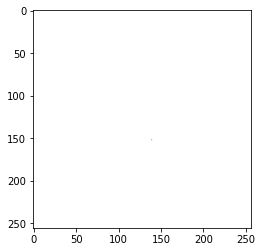

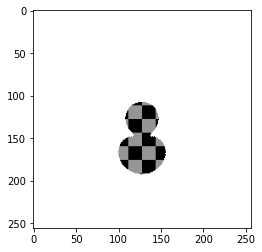

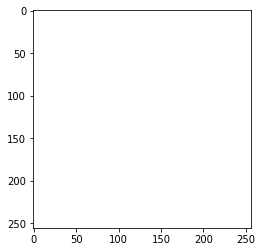

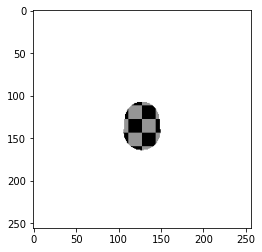

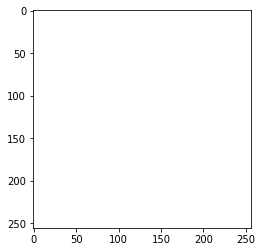

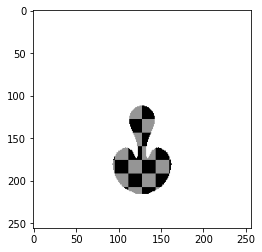

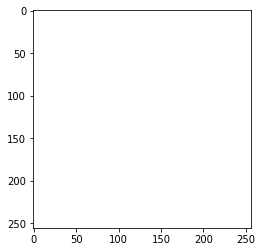

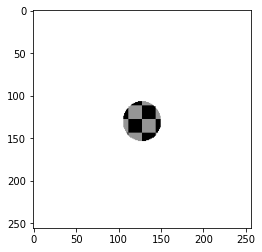

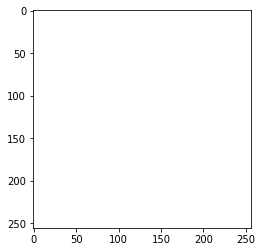

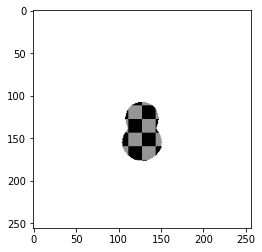

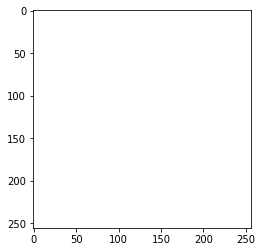

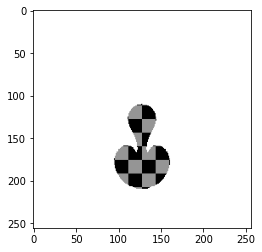

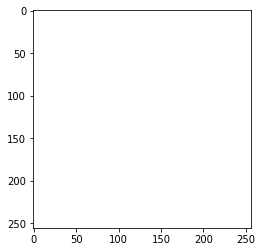

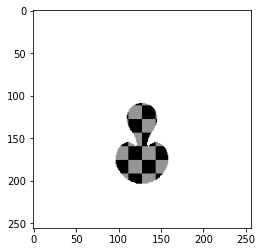

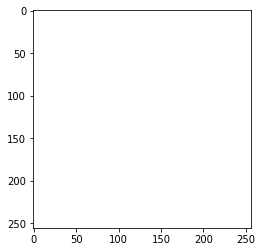

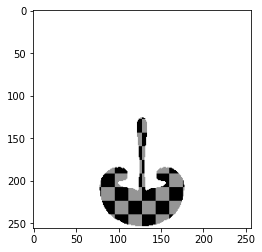

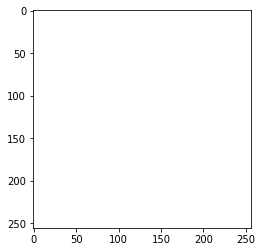

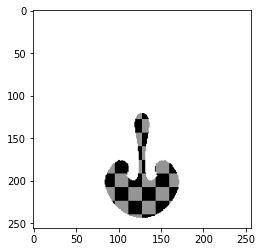

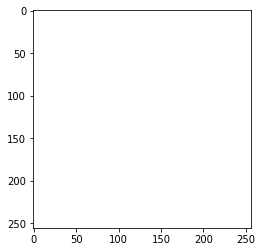

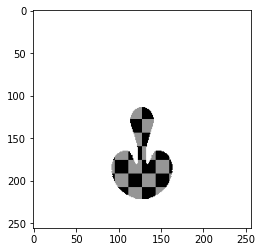

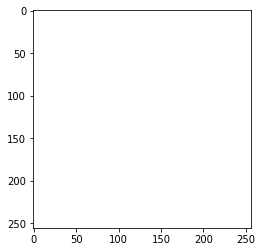

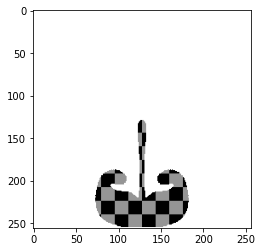

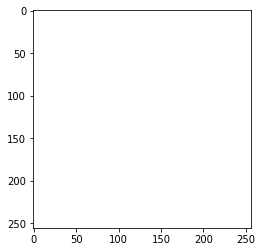

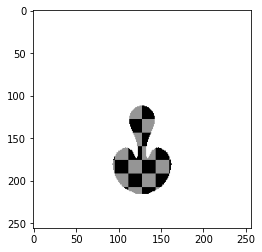

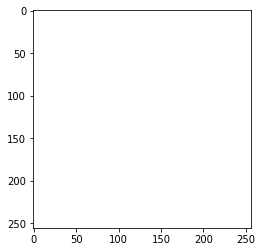

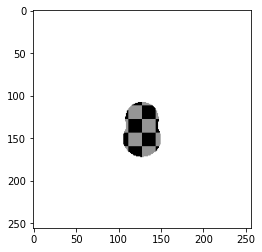

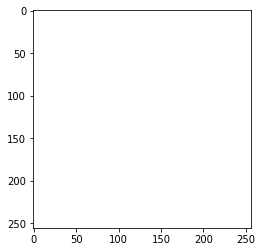

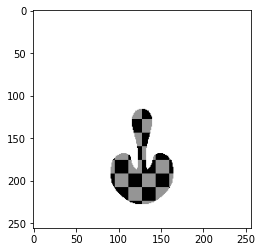

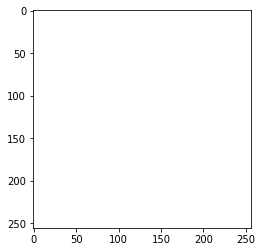

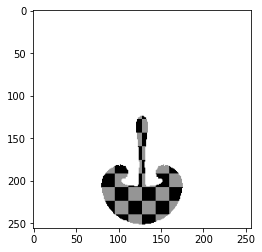

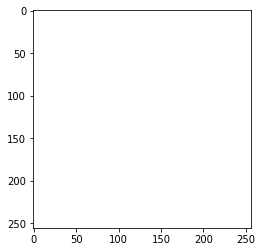

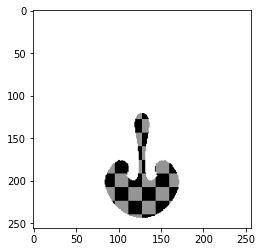

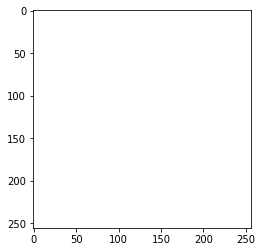

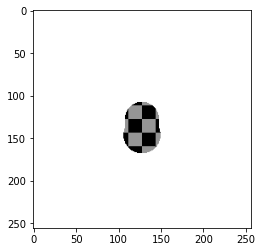

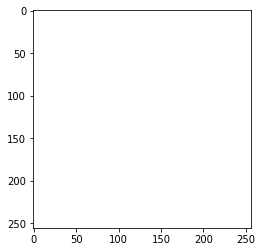

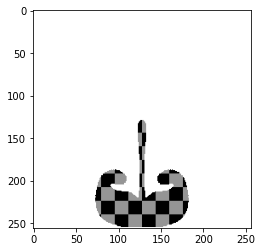

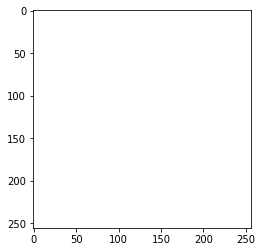

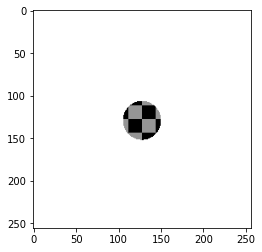

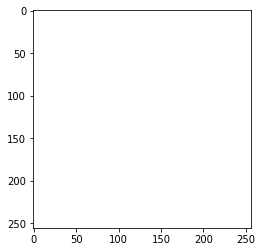

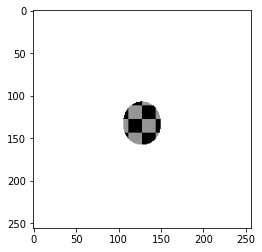

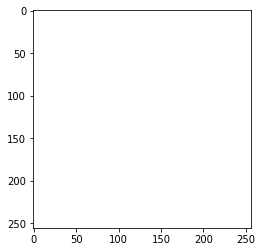

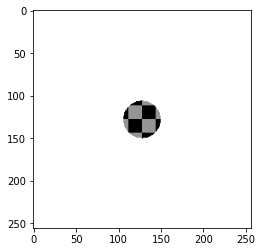

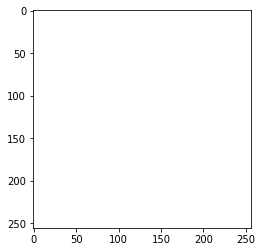

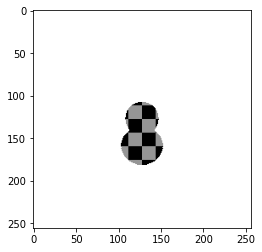

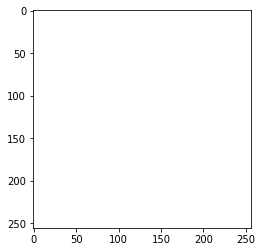

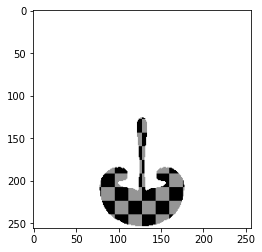

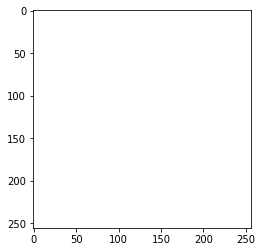

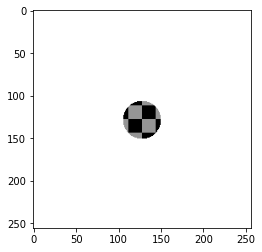

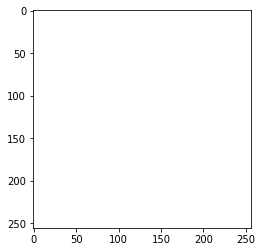

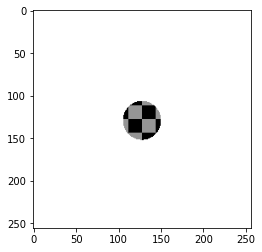

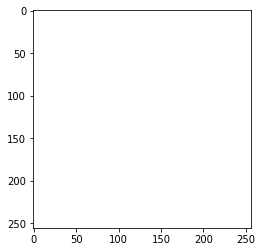

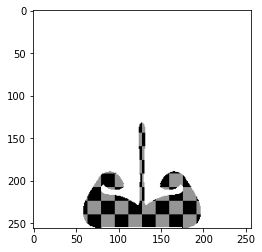

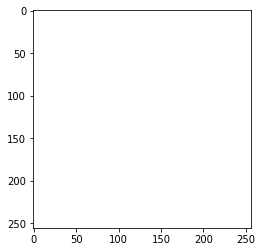

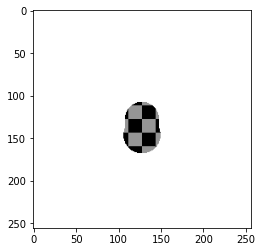

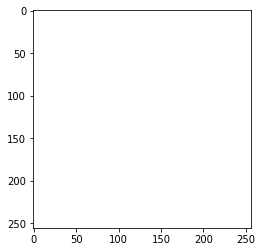

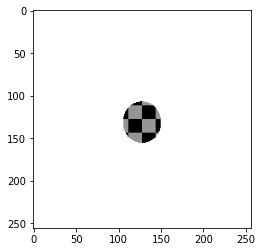

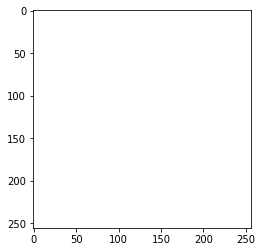

KeyboardInterrupt: ignored

In [20]:
model = NNA(n_channels)

start_frame = 0
end_frame = 40
max_frame_steps = 10
extra_steps = 20

alpha = 0.001

init = tf.convert_to_tensor(np.concatenate((dataset[start_frame],np.ones((1,size,size,hidden_channels))) , axis = -1))

#@title lets try to add some styling { vertical-output: true}
def train_step_frame_at_a_time(dataset):
    frame_steps = tf.random.uniform([],1,max_frame_steps,tf.int32)
    loss = 0
    random_frame_idx = np.random.randint(start_frame,end_frame-max_frame_steps)
    x = tf.convert_to_tensor(np.concatenate((dataset[random_frame_idx],np.ones((1,size,size,hidden_channels))) , axis = -1))
    with tf.GradientTape() as g:        
        for i in tf.range(frame_steps):
          for j in tf.range(extra_steps):
              x = model(x , mask= True)
        state = np.where(dataset[random_frame_idx+frame_steps], (ckbrd + 0.5) / 2, 0)
        plot(state)
        plot(x)
        loss_classic = loss_object(grayscale_m(state), grayscale_m(x))
        loss += loss_classic
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

EPOCHS = 501
losses = []
for epoch in range(EPOCHS):
    x, loss = train_step_frame_at_a_time(dataset)
    losses.append(loss)
    if epoch % 50 == 0:
      print(f'Epoch {epoch} , Loss {loss}')
      modelToGif(model, init ,1000 , interval=50 ,  mask= True)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()